https://www.comunidadedatascience.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

# 0. IMPORTS

In [1]:
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

## 0.0. Helper Functions

## 0.1. Loading Data

- id = Unique ID for the customer
- Gender = Gender of the customer
- Age = Age of the customer
- Driving_License = 0: Customer does not have DL; 1: Customer already has DL
- Region_Code = Unique code for the region of the customer
- Previously_Insured = 1: Customer already has Vehicle Insurance; 0: Customer doesn't have Vehicle Insurance
- Vehicle_Age = Age of the Vehicle
- Vehicle_Damage = 1: Customer got his/her vehicle damaged in the past; 0: Customer didn't get his/her vehicle damaged in the past.
- Annual_Premium = The amount customer needs to pay as premium in the year
- PolicySalesChannel = Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- Vintage = Number of Days, Customer has been associated with the company
- Response = 1: Customer is interested; 0: Customer is not interested

In [2]:
# Credentials SQL
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

In [3]:
query = """
        select * from pa004.insurance i inner join pa004.users u on i.id = u.id 
                                  inner join pa004.vehicle v on v.id = u.id order by i.id ASC
"""

In [4]:
string_connect = 'postgresql://' + username + ':' + pwd + '@' + host + ':' + str(port) + '/' + database
engine = sa.create_engine(string_connect)
conn1 = engine.connect()
df_raw = pd.read_sql(query, conn1)

In [5]:
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]

In [6]:
df_raw

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,40454.0,217,1,Male,44,28.0,26.0,1,> 2 Years,Yes
1,2,0,33536.0,183,0,Male,76,3.0,26.0,1,1-2 Year,No
2,3,0,38294.0,27,1,Male,47,28.0,26.0,1,> 2 Years,Yes
3,4,1,28619.0,203,0,Male,21,11.0,152.0,1,< 1 Year,No
4,5,1,27496.0,39,0,Female,29,41.0,152.0,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,30170.0,88,0,Male,74,26.0,26.0,1,1-2 Year,No
381105,381106,1,40016.0,131,0,Male,30,37.0,152.0,1,< 1 Year,No
381106,381107,1,35118.0,161,0,Male,21,30.0,160.0,1,< 1 Year,No
381107,381108,0,44617.0,74,0,Female,68,14.0,124.0,1,> 2 Years,Yes


# 1. DATA DESCRIPTION

In [7]:
df1 = df_raw.copy()

## 1.0. Rename Columns

In [8]:
df1.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'response',
       'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage'],
      dtype='object')

## 1.1. Data Dimensions

In [9]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [10]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.3. Check NA

In [11]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4. Fill out NA

There is no NA in the dataset

## 1.5. Change Types

In [12]:
df1['previously_insured'].value_counts()

0    206481
1    174628
Name: previously_insured, dtype: int64

In [13]:
df1['driving_license'].value_counts()

1    380297
0       812
Name: driving_license, dtype: int64

In [14]:
df1['vehicle_damage'].value_counts()

Yes    192413
No     188696
Name: vehicle_damage, dtype: int64

In [15]:
df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [16]:
df1['region_code'].value_counts()

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: region_code, dtype: int64

In [17]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['vehicle_damage'] = df1['vehicle_damage'].astype('int64')

In [18]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage            int64
dtype: object

## 1.6. Descriptive statistics

In [19]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
vehicle_damage,381109.0,0.504877,0.499977,0.0,0.0,1.0,1.0,1.0


In [20]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.0. Numerical Attributes

In [21]:
# Central Tentency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
2,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
3,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
4,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
5,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
6,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
9,vehicle_damage,0.0,1.0,1.0,0.504877,1.0,0.499976,-1.950724e-02,-1.999630


C:\Users\gabriellima\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


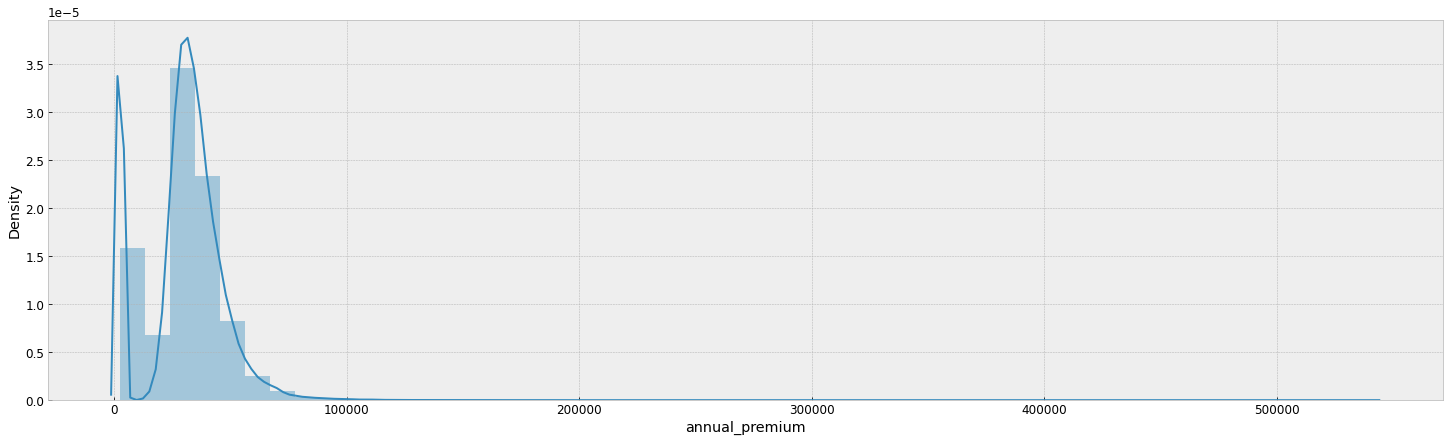

In [22]:
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 7]
plt.rcParams['font.size'] = 12

sns.distplot(df1['annual_premium']);

### 1.6.1. Categorical Attributes

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender         2
vehicle_age    3
dtype: int64

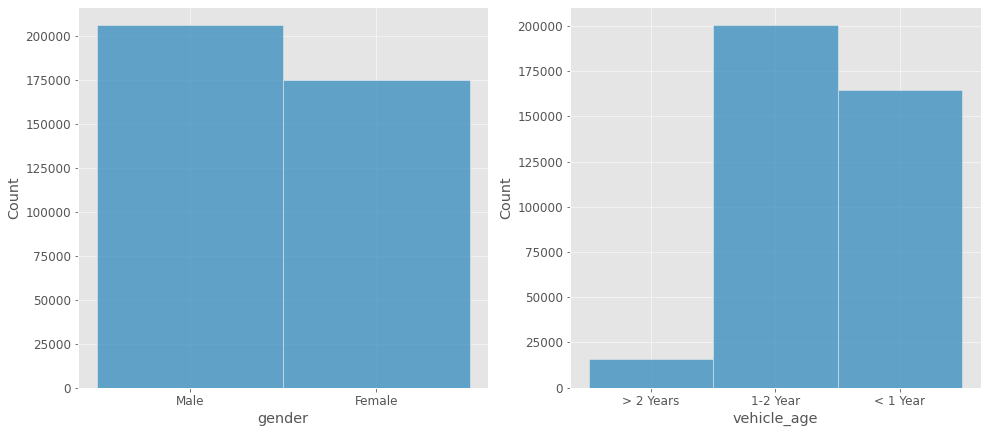

In [24]:
plt.style.use( 'ggplot' )
plt.rcParams['figure.figsize'] = [25, 7]
plt.rcParams['font.size'] = 12

plt.subplot(1, 3, 1)
sns.histplot(x='gender', data=df1);

plt.subplot(1, 3, 2)
sns.histplot(x='vehicle_age', data=df1);

# 2. FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

No feature engineering to do yet.

# 3. VARIABLE FILTERING

In [26]:
df3 = df2.copy()

No variable filtering to do yet.

# 4. EXPLORATION DATA ANALYSIS


In [27]:
df4 = df3.copy()

## 4.0. Univariate Analysis

### Response

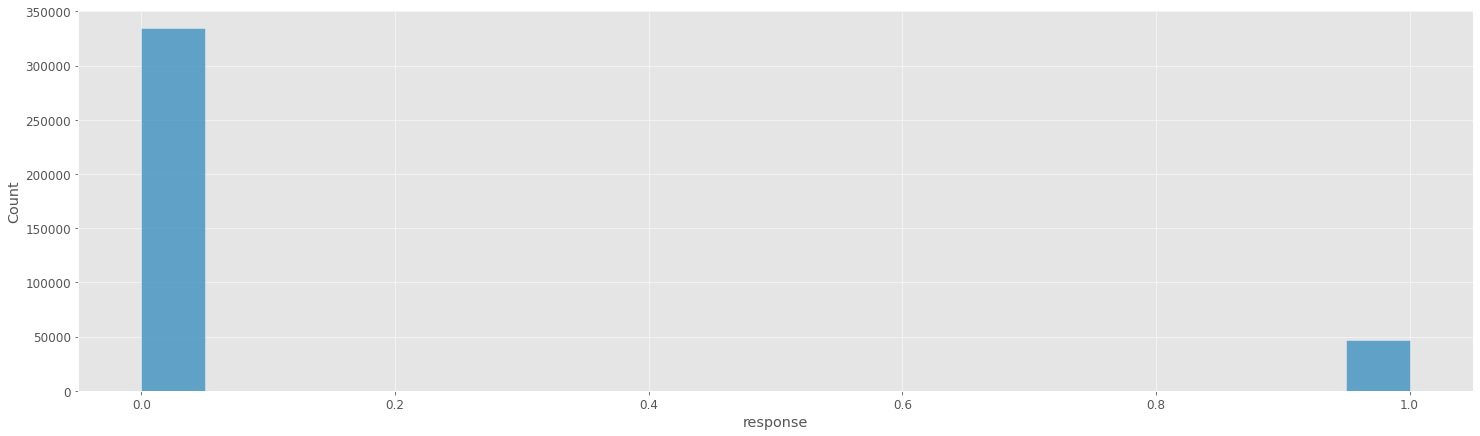

In [28]:
sns.histplot(df4['response']);

### Numerical Variable

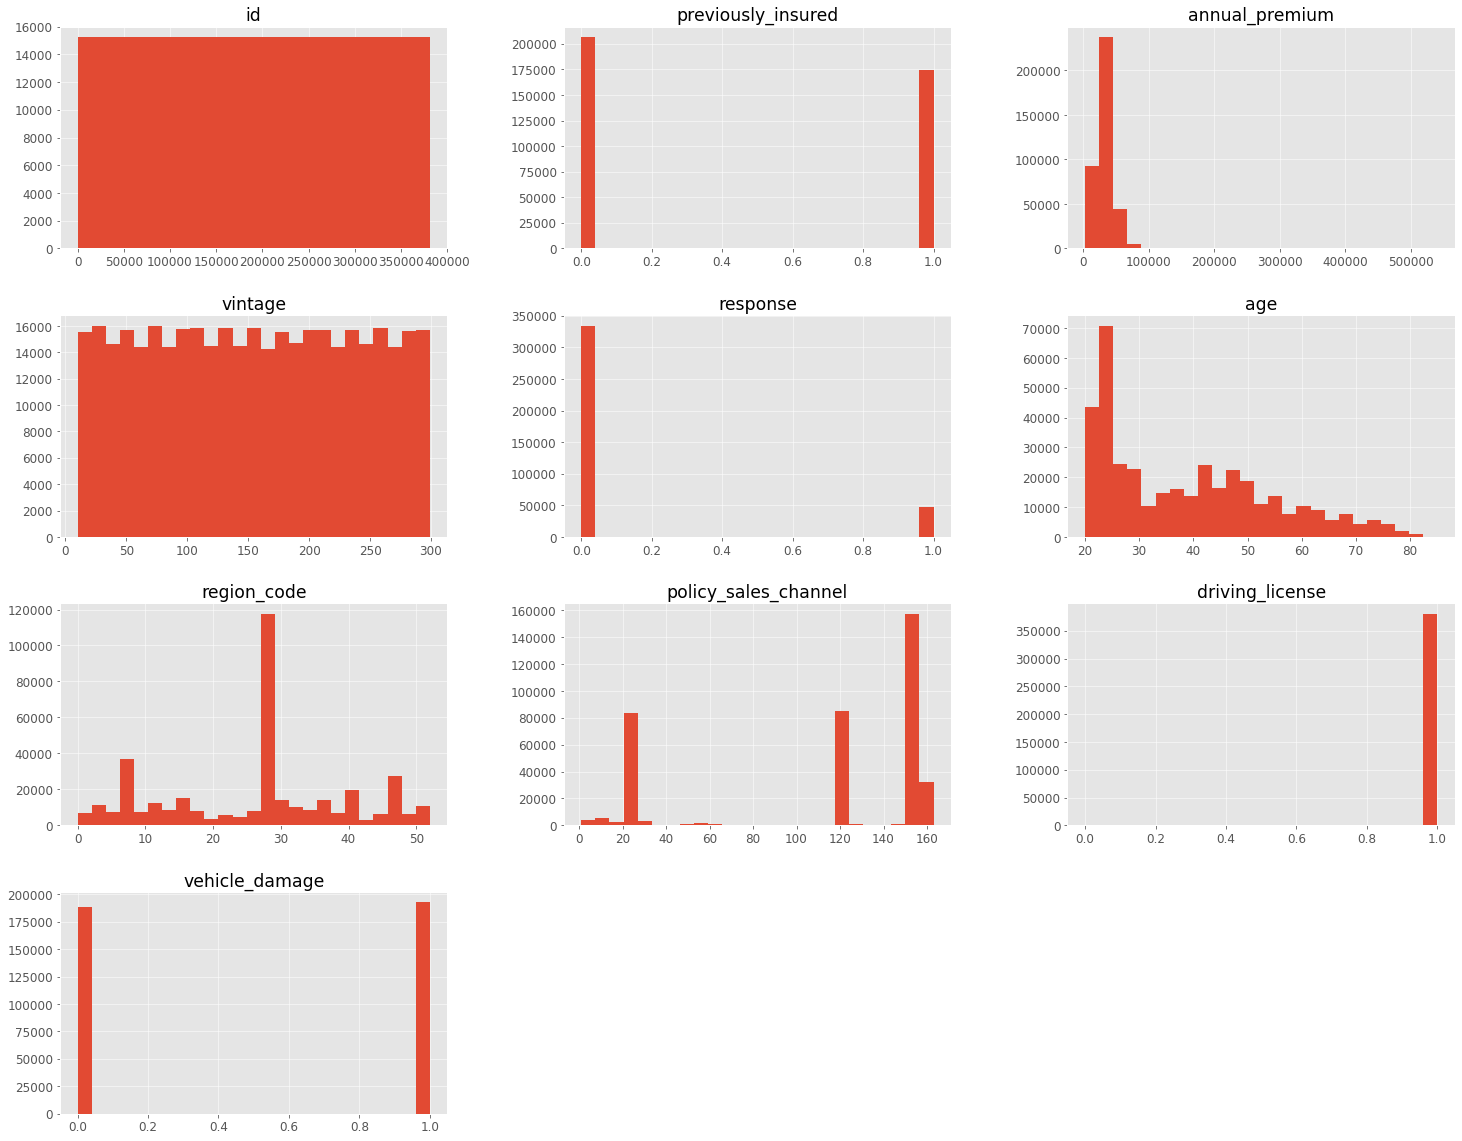

In [29]:
plt.rcParams['figure.figsize'] = [25, 20]
num_attributes.hist(bins=25);

### Categorical Variable

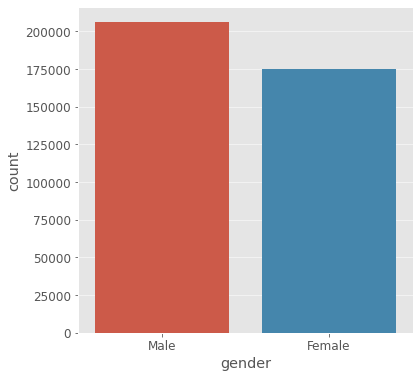

In [30]:
plt.figure(figsize=(6,6))
sns.countplot(x=df4['gender']);

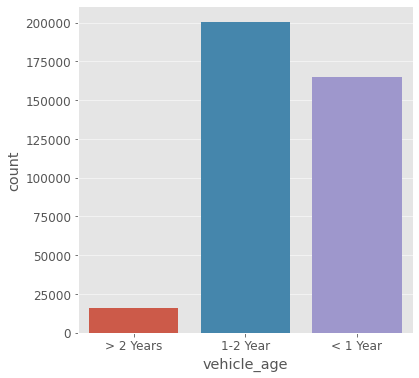

In [31]:
plt.figure(figsize=(6,6))
sns.countplot(x=df4['vehicle_age']);

## 4.1. Bivariate Analysis

### age

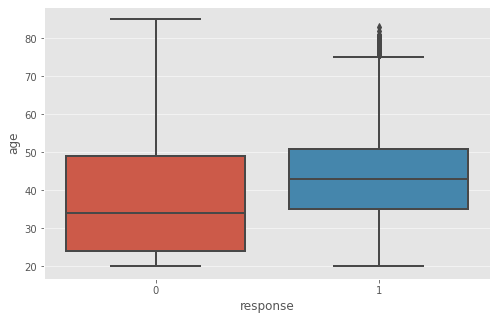

In [32]:
# age
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [8, 5]
sns.boxplot(x='response', y='age', data=df4);

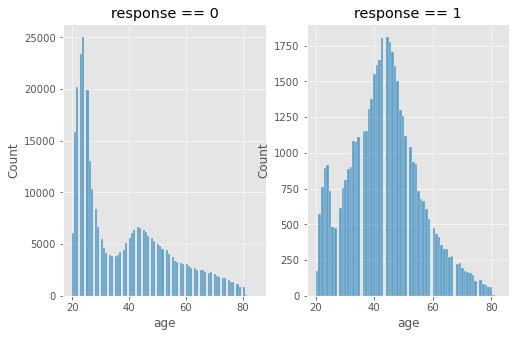

In [33]:
plt.subplot(1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00);
plt.title('response == 0');

plt.subplot(1, 2, 2)
aux01 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux01);
plt.title('response == 1');

### annual_premium

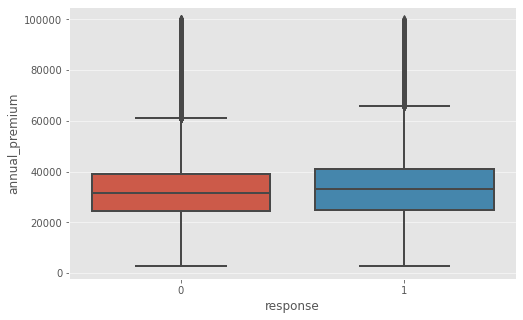

In [34]:
# annual_premium
plt.rcParams['figure.figsize'] = [8, 5]
aux = df4[df4['annual_premium'] <= 100000]
sns.boxplot(x='response', y='annual_premium', data=aux);

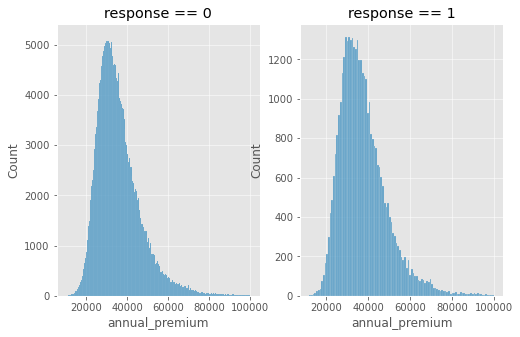

In [35]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] <= 100000)]
plt.subplot(1, 2, 1)
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00);
plt.title('response == 0');

plt.subplot(1, 2, 2)
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux01);
plt.title('response == 1');

### gender

In [36]:
aux = df4[df4['response'] == 1]['gender']
print('Gender with response == 1')
print(aux.value_counts(normalize=True).reset_index())

print()
aux = df4[df4['response'] == 0]['gender']
print('Gender with response == 0')
print(aux.value_counts(normalize=True).reset_index())

print()
print('Total Gender')
aux = df4['gender']
print(aux.value_counts(normalize=True).reset_index())

Gender with response == 1
    index    gender
0    Male  0.610683
1  Female  0.389317

Gender with response == 0
    index    gender
0    Male  0.530994
1  Female  0.469006

Total Gender
    index    gender
0    Male  0.540761
1  Female  0.459239


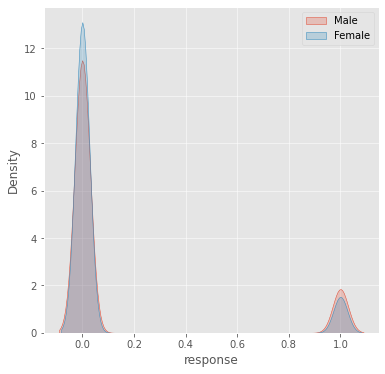

In [37]:
aux_g = df4['gender'].unique()
plt.figure(figsize=(6,6))
sns.kdeplot(df4[df4['gender'] == aux_g[0]]['response'], shade=True, label=aux_g[0]);
sns.kdeplot(df4[df4['gender'] == aux_g[1]]['response'], shade=True, label=aux_g[1]);
plt.legend();

### driving_license

In [38]:
aux = df4.pivot_table(index='response', values='driving_license', aggfunc='sum').reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


### region_code

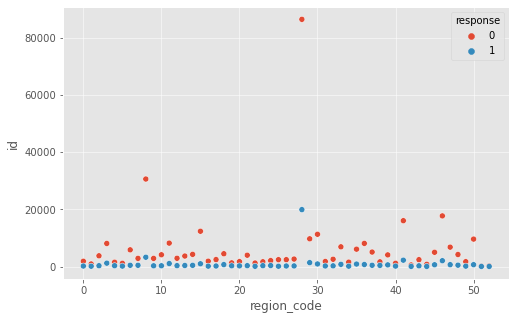

In [39]:
aux = df4.pivot_table(index=['region_code', 'response'], values='id', aggfunc='count').reset_index()
plt.rcParams['figure.figsize'] = [8, 5]
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

### previously_insured

In [40]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### vehicle_age

In [41]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


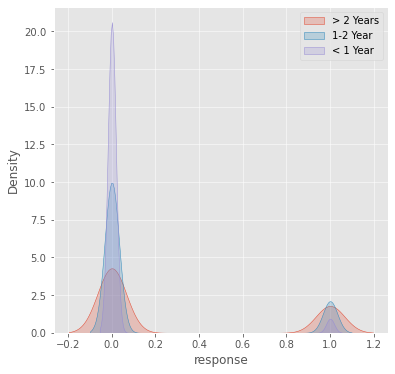

In [42]:
v_a = df4['vehicle_age'].unique()
plt.figure(figsize=(6,6))
sns.kdeplot(df4[df4['vehicle_age'] == v_a[0]]['response'], shade=True, label=v_a[0]);
sns.kdeplot(df4[df4['vehicle_age'] == v_a[1]]['response'], shade=True, label=v_a[1]);
sns.kdeplot(df4[df4['vehicle_age'] == v_a[2]]['response'], shade=True, label=v_a[2]);
plt.legend();

### policy_sales_channel

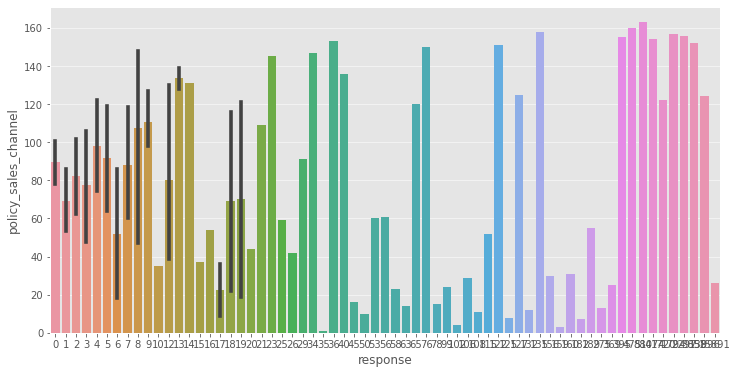

In [43]:
aux = df4.pivot_table(index='policy_sales_channel', values='response', aggfunc='sum').reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='response', y='policy_sales_channel', data=aux);

### vintage

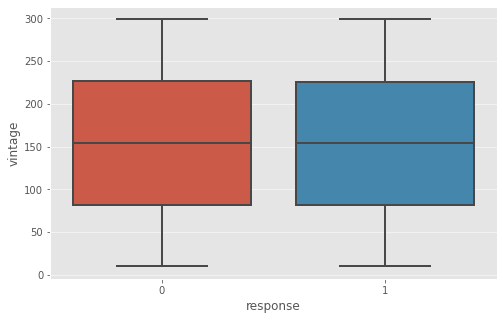

In [44]:
plt.rcParams['figure.figsize'] = [8, 5]
sns.boxplot(x='response', y='vintage', data=df4);

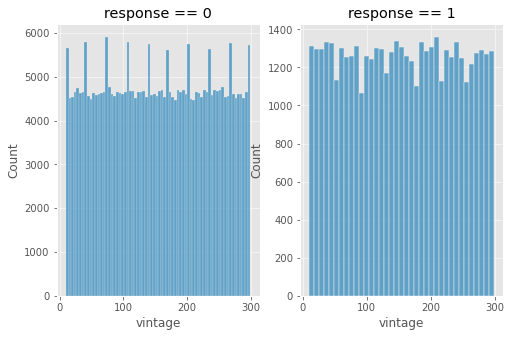

In [45]:
plt.subplot(1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00);
plt.title('response == 0');

plt.subplot(1, 2, 2)
aux01 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux01);
plt.title('response == 1');

## 4.2. Multivariate Analysis

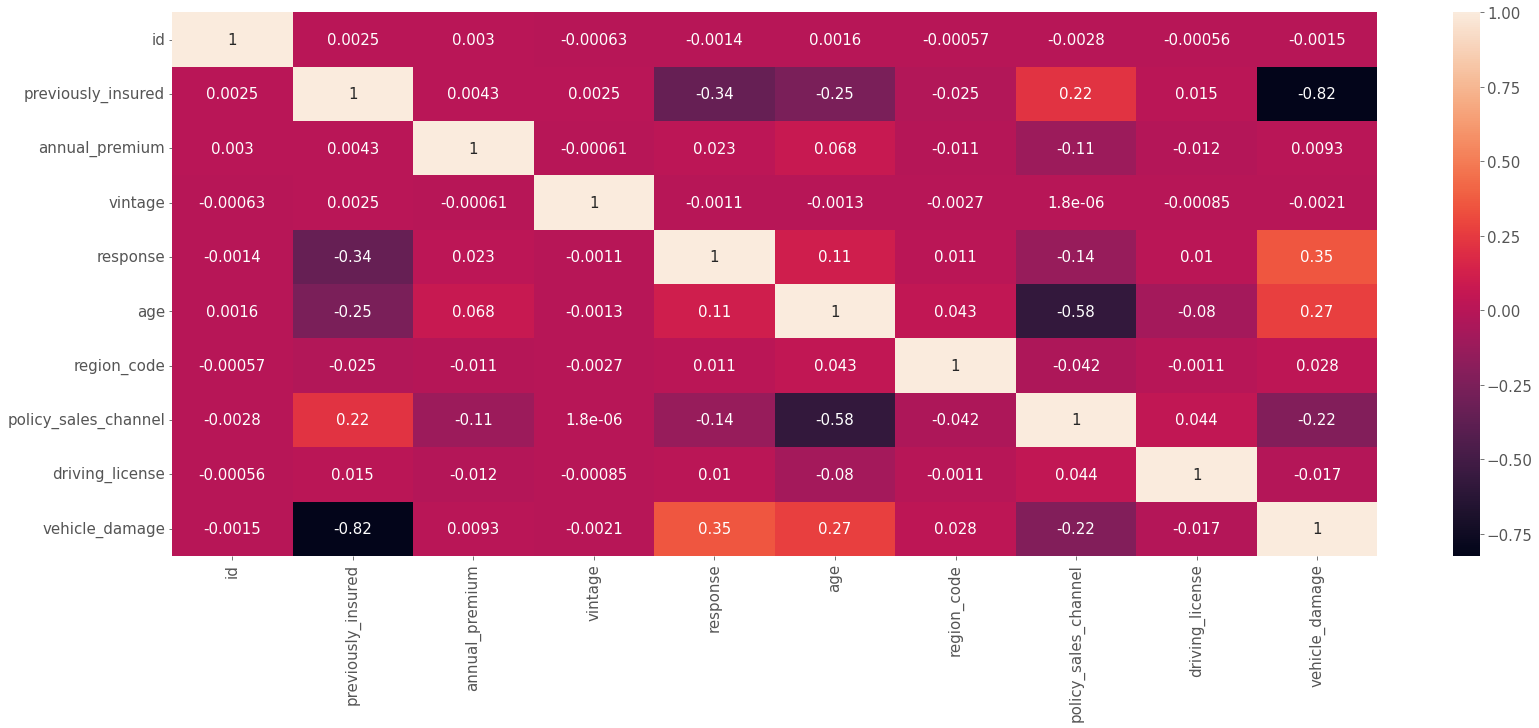

In [46]:
plt.rcParams['figure.figsize'] = [27, 10]
plt.rcParams.update({'font.size': 15})
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 5. DATA PREPARATION

In [47]:
df5 = df4.copy()

In [48]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.0. Standardization

In [49]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.1. Rescaling

In [50]:
# age 
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
mms_vintage = pp.MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.2. Encoding

In [51]:
# region_code
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# gender
df5 = pd.get_dummies(df5, columns=['gender'])

# vehicle_age
df5 = pd.get_dummies(df5, columns=['vehicle_age'])

# policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

df5 = df5.drop(['vehicle_age_> 2 Years', 'gender_Male'], axis=1)

## 5.3. Validation Preparation

In [52]:
# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

# vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# region_code
x_val.loc[:, 'region_code'] = x_val['region_code'].map(target_encode_region_code)

# gender
x_val = pd.get_dummies(x_val, columns=['gender'])

# vehicle_age
x_val = pd.get_dummies(x_val, columns=['vehicle_age'])

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# fill na
x_val = x_val.fillna(0)

x_val = x_val.drop(['vehicle_age_> 2 Years', 'gender_Male'], axis=1)

# 6. FEATURE SELECTION

In [53]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                feature  importance
0               vintage    0.276686
0        annual_premium    0.246432
0                   age    0.161018
0           region_code    0.103902
0        vehicle_damage    0.072169
0  policy_sales_channel    0.060651
0    previously_insured    0.052111
0  vehicle_age_< 1 Year    0.014289
0  vehicle_age_1-2 Year    0.006997
0         gender_Female    0.005255
0       driving_license    0.000490


<Figure size 600x600 with 0 Axes>

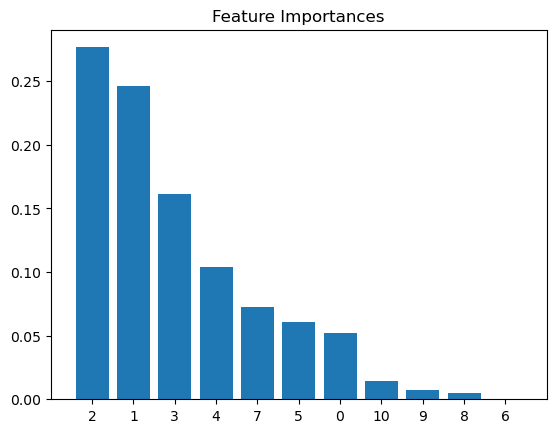

In [54]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.style.use('default')
plt.figure(figsize=(6,6))
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

# 7. MACHINE LEARNING

In [55]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df5[cols_selected]
x_val1 = x_val[cols_selected].copy()

## 7.0. KNN

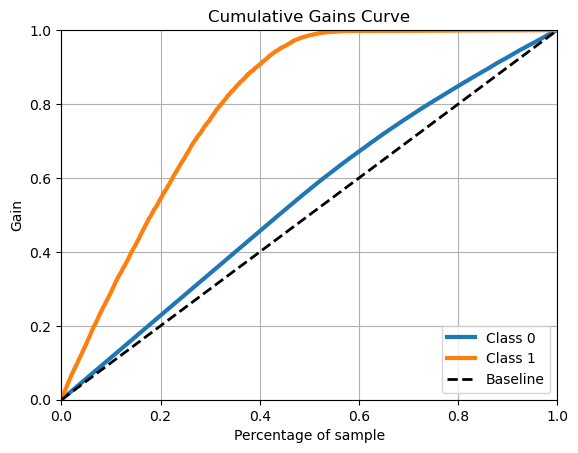

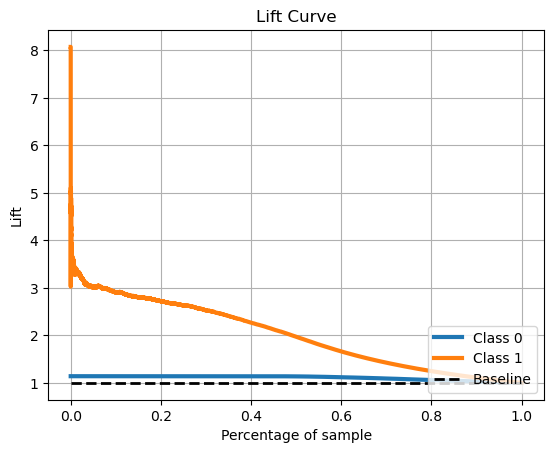

In [56]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=100)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Poder de GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(x_val1)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn);

## 7.1. Logistic Regression

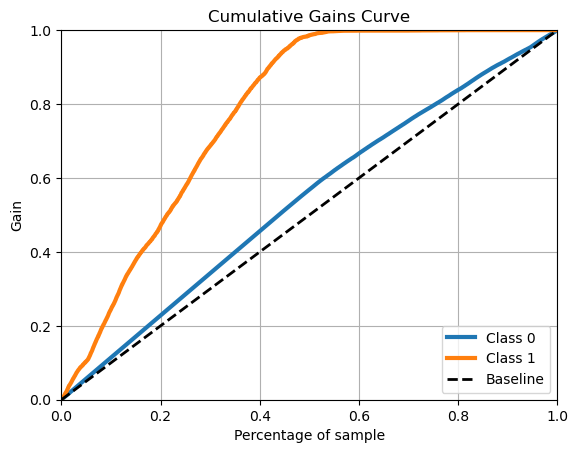

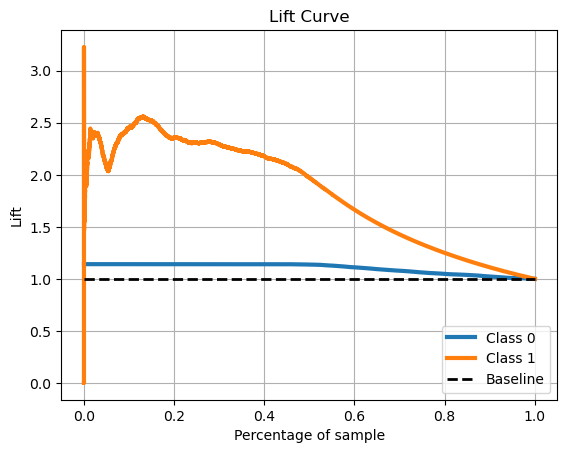

In [57]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction - Poder de GENERALIZAÇÃO
yhat_lr = lr_model.predict_proba(x_val1)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

## 7.2. Random Forest

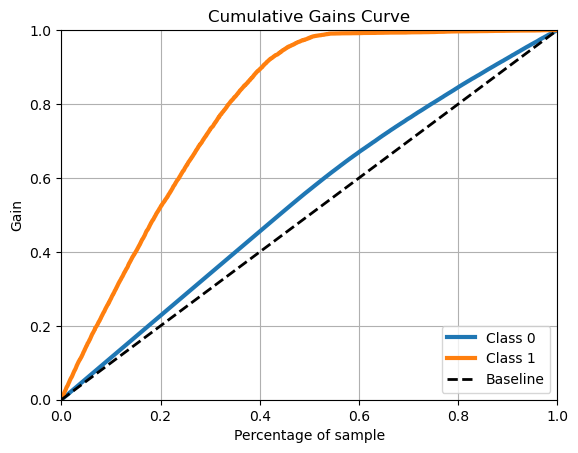

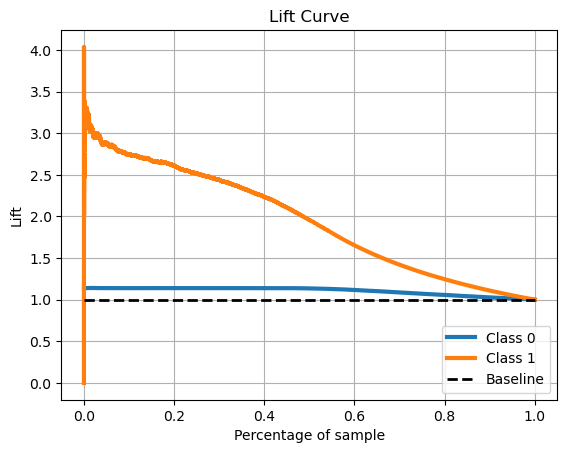

In [58]:
# model definition
rf_model = en.RandomForestClassifier()

# model training
rf_model.fit(x_train, y_train)

# model prediction - Poder de GENERALIZAÇÃO
yhat_rf = rf_model.predict_proba(x_val1)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf);